# Urinary Tract Infection Prediction

This project focuses on machine learning model development. We will use an open, de-identified data set used by a team within the Yale system in the past to predict urinary tract infections

#### Library import

In [1]:
import pandas as pd
import numpy as np
import psycopg2
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from datetime import date, datetime
from dateutil.relativedelta import relativedelta
from getpass import getpass
from sqlalchemy import create_engine
from matplotlib import pyplot as plt
import missingno as msno
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import chi2, f_classif
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from tabulate import tabulate
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [2]:
# URL
url = "https://journals.plos.org/plosone/article/file?type=supplementary&id=info:doi/10.1371/journal.pone.0194085.s001"

df = pd.read_csv(url)

In [3]:
pd.set_option('display.max_columns', None)
df.head()

,ID,PATID,UCX_abnormal,ua_bacteria,ua_bili,ua_blood,ua_clarity,ua_color,ua_epi,ua_glucose,ua_ketones,ua_leuk,ua_nitrite,ua_ph,ua_protein,ua_rbc,ua_spec_grav,ua_urobili,ua_wbc,CVA_tenderness,abd_tenderness,abd_soft,abd_distended,abd_gaurding,abd_mass,abd_rebound,abd_rigidity,back_pain,fatigue,fever,vag_bleeding,vag_discharge,abd_distended2,abd_pain,gen_neg,pelvic_pain,alert,ams,weakness,oriented,psychiatric_confusion,flank_pain,dec_urine_vol,diff_urinating,dysuria,hematuria,polyuria,chief_complaint,age,gender,race,ethnicity,lang,maritalStatus,employStatus,insurance_status,disposition,arrival,Temp_First,Temp_Last,Temp_Max,Temp_Min,Temp_Mean,HR_First,HR_Last,HR_Max,HR_Min,HR_Mean,SBP_First,SBP_Last,SBP_Max,SBP_Min,SBP_Mean,DBP_First,DBP_Last,DBP_Max,DBP_Min,DBP_Mean,RR_First,RR_Last,RR_Max,RR_Min,RR_Mean,O2_Sat_First,O2_Sat_Last,O2_Sat_Max,O2_Sat_Min,O2_Sat_Mean,O2_Amount_First,O2_Amount_Last,O2_Amount_Max,O2_Amount_Min,O2_Amount_Mean,O2_Dependency_First,O2_Dependency_Last,GCS_First,GCS_Last,Absolute_Lymphocyte_Count,Alanine_Aminotransferase,Alkaline_Phosphatase,ANC,Anion_Gap,Aspartate_Aminotransferase,Basophils,BUN,Calcium,Chloride,CO2,Creatinine,Eosinophils,Glucose,Hematocrit,Hemoglobin,Lymphocytes,MCH,MCHC,MCV,Monocytes,MPV,Neutrophils,Platelets,Potassium,RBC,RDW,Sodium,WBC,abx,Abdominal_hernia,Abdominal_pain,Acute_and_unspecified_renal_failure,Anal_and_rectal_conditions,Calculus_of_urinary_tract,Cancer,Chronic_renal_failure,Congestive_heart_failure__nonhypertensive,Coronary_atherosclerosis_and_other_heart_disease,Delirium__dementia__and_amnestic_and_other_cognitive_disorders,Diabetes_mellitus_with_complications,Diabetes_mellitus_without_complication,Diabetes_or_abnormal_glucose_tolerance_complicating_pregnancy__childbirth__or_the_puerperium,Genitourinary_congenital_anomalies,Genitourinary_symptoms_and_ill_defined_conditions,Heart_valve_disorders,HIV_infection,Hodgkins_disease,Hyperplasia_of_prostate,Inflammatory_conditions_of_male_genital_organs,Leukemias,Maintenance_chemotherapy__radiotherapy,Menstrual_disorders,Nephritis__nephrosis__renal_sclerosis,Non_Hodgkins_lymphoma,Other_and_ill_defined_heart_disease,Other_female_genital_disorders,Other_male_genital_disorders,Other_non_epithelial_cancer_of_skin,Pancreatic_disorders__not_diabetes_,Paralysis,Parkinsons_disease,Poisoning_by_nonmedicinal_substances,Prolapse_of_female_genital_organs,Pulmonary_heart_disease,Screening_and_history_of_mental_health_and_substance_abuse_codes,Septicemia__except_in_labor_,Sexually_transmitted_infections__not_HIV_or_hepatitis_,Substance_related_disorders,Urinary_tract_infections,ANALGESIC_AND_ANTIHISTAMINE_COMBINATION,ANALGESICS,ANESTHETICS,ANTI_OBESITY_DRUGS,ANTIALLERGY,ANTIARTHRITICS,ANTIASTHMATICS,ANTIBIOTICS,ANTICOAGULANTS,ANTIDOTES,ANTIFUNGALS,ANTIHISTAMINE_AND_DECONGESTANT_COMBINATION,ANTIHISTAMINES,ANTIHYPERGLYCEMICS,ANTIINFECTIVES,ANTIINFECTIVES_MISCELLANEOUS,ANTINEOPLASTICS,ANTIPARKINSON_DRUGS,ANTIPLATELET_DRUGS,ANTIVIRALS,AUTONOMIC_DRUGS,BIOLOGICALS,BLOOD,CARDIAC_DRUGS,CARDIOVASCULAR,CNS_DRUGS,COLONY_STIMULATING_FACTORS,CONTRACEPTIVES,COUGH_COLD_PREPARATIONS,DIAGNOSTIC,DIURETICS,EENT_PREPS,ELECT_CALORIC_H2O,GASTROINTESTINAL,HERBALS,HORMONES,IMMUNOSUPPRESANT,INVESTIGATIONAL,MISCELLANEOUS_MEDICAL_SUPPLIES__DEVICES__NON_DRUG,MUSCLE_RELAXANTS,PRE_NATAL_VITAMINS,PSYCHOTHERAPEUTIC_DRUGS,SEDATIVE_HYPNOTICS,SKIN_PREPS,SMOKING_DETERRENTS,THYROID_PREPS,UNCLASSIFIED_DRUG_PRODUCTS,VITAMINS,dispo,UTI_diag,split,abxUTI,alt_diag
0,1,1,yes,few,negative,negative,clear,yellow,small,negative,negative,small,negative,7.5,negative,small,1.020,negative,moderate,0,1,not_reported,not_reported,1,0,0,0,0,0,0,not_reported,not_reported,not_reported,1,1,not_reported,1,not_reported,not_reported,1,not_reported,not_reported,not_reported,not_reported,not_reported,not_reported,not_reported,ABDOMINAL PAIN,83,Female,Other,Hispanic or Latino,Non-English,Widowed,Not Employed,Commercial,Admit,Car,5,5,5,5,5,5,5,5,5,5,4,4,4,4,4,3,3,3,3,3,1,1,1,1,1,4,4,4,4,4,not_reported,not_repor

In [4]:
df.shape

(80387, 220)

In [5]:
# Dropping columns
df.drop(columns=['split','abxUTI','alt_diag', 'ID','PATID'],inplace=True)

#### Exploratory Data Analysis

In [6]:
# Columns with numeric variables
num_vars = df.select_dtypes(include=['float64', 'int64'])
num_vars.columns

Index(['ua_spec_grav', 'age'], dtype='object')

In [7]:
# Summary statistics
num_vars.describe()

,ua_spec_grav,age
count,80387.000000,80387.000000
mean,1.019084,53.801436
std,0.018803,22.250829
min,0.018000,18.000000
25%,1.013000,34.000000
50%,1.018000,53.000000
75%,1.025000,72.000000
max,5.500000,109.000000


In [8]:
# Columns with categorical variables
cat_vars = df.select_dtypes(include=['object'])
cat_vars.columns

Index(['UCX_abnormal', 'ua_bacteria', 'ua_bili', 'ua_blood', 'ua_clarity',
       'ua_color', 'ua_epi', 'ua_glucose', 'ua_ketones', 'ua_leuk',
       ...
       'PRE_NATAL_VITAMINS', 'PSYCHOTHERAPEUTIC_DRUGS', 'SEDATIVE_HYPNOTICS',
       'SKIN_PREPS', 'SMOKING_DETERRENTS', 'THYROID_PREPS',
       'UNCLASSIFIED_DRUG_PRODUCTS', 'VITAMINS', 'dispo', 'UTI_diag'],
      dtype='object', length=213)

In [9]:
## summary statistics for categorical variables
cat_vars.describe()

,UCX_abnormal,ua_bacteria,ua_bili,ua_blood,ua_clarity,ua_color,ua_epi,ua_glucose,ua_ketones,ua_leuk,ua_nitrite,ua_ph,ua_protein,ua_rbc,ua_urobili,ua_wbc,CVA_tenderness,abd_tenderness,abd_soft,abd_distended,abd_gaurding,abd_mass,abd_rebound,abd_rigidity,back_pain,fatigue,fever,vag_bleeding,vag_discharge,abd_distended2,abd_pain,gen_neg,pelvic_pain,alert,ams,weakness,oriented,psychiatric_confusion,flank_pain,dec_urine_vol,diff_urinating,dysuria,hematuria,polyuria,chief_complaint,gender,race,ethnicity,lang,maritalStatus,employStatus,insurance_status,disposition,arrival,Temp_First,Temp_Last,Temp_Max,Temp_Min,Temp_Mean,HR_First,HR_Last,HR_Max,HR_Min,HR_Mean,SBP_First,SBP_Last,SBP_Max,SBP_Min,SBP_Mean,DBP_First,DBP_Last,DBP_Max,DBP_Min,DBP_Mean,RR_First,RR_Last,RR_Max,RR_Min,RR_Mean,O2_Sat_First,O2_Sat_Last,O2_Sat_Max,O2_Sat_Min,O2_Sat_Mean,O2_Amount_First,O2_Amount_Last,O2_Amount_Max,O2_Amount_Min,O2_Amount_Mean,O2_Dependency_First,O2_Dependency_Last,GCS_First,GCS_Last,Absolute_Lymphocyte_Count,Alanine_Aminotransferase,Alkaline_Phosphatase,ANC,Anion_Gap,Aspartate_Aminotransferase,Basophils,BUN,Calcium,Chloride,CO2,Creatinine,Eosinophils,Glucose,Hematocrit,Hemoglobin,Lymphocytes,MCH,MCHC,MCV,Monocytes,MPV,Neutrophils,Platelets,Potassium,RBC,RDW,Sodium,WBC,abx,Abdominal_hernia,Abdominal_pain,Acute_and_unspecified_renal_failure,Anal_and_rectal_conditions,Calculus_of_urinary_tract,Cancer,Chronic_renal_failure,Congestive_heart_failure__nonhypertensive,Coronary_atherosclerosis_and_other_heart_disease,Delirium__dementia__and_amnestic_and_other_cognitive_disorders,Diabetes_mellitus_with_complications,Diabetes_mellitus_without_complication,Diabetes_or_abnormal_glucose_tolerance_complicating_pregnancy__childbirth__or_the_puerperium,Genitourinary_congenital_anomalies,Genitourinary_symptoms_and_ill_defined_conditions,Heart_valve_disorders,HIV_infection,Hodgkins_disease,Hyperplasia_of_prostate,Inflammatory_conditions_of_male_genital_organs,Leukemias,Maintenance_chemotherapy__radiotherapy,Menstrual_disorders,Nephritis__nephrosis__renal_sclerosis,Non_Hodgkins_lymphoma,Other_and_ill_defined_heart_disease,Other_female_genital_disorders,Other_male_genital_disorders,Other_non_epithelial_cancer_of_skin,Pancreatic_disorders__not_diabetes_,Paralysis,Parkinsons_disease,Poisoning_by_nonmedicinal_substances,Prolapse_of_female_genital_organs,Pulmonary_heart_disease,Screening_and_history_of_mental_health_and_substance_abuse_codes,Septicemia__except_in_labor_,Sexually_transmitted_infections__not_HIV_or_hepatitis_,Substance_related_disorders,Urinary_tract_infections,ANALGESIC_AND_ANTIHISTAMINE_COMBINATION,ANALGESICS,ANESTHETICS,ANTI_OBESITY_DRUGS,ANTIALLERGY,ANTIARTHRITICS,ANTIASTHMATICS,ANTIBIOTICS,ANTICOAGULANTS,ANTIDOTES,ANTIFUNGALS,ANTIHISTAMINE_AND_DECONGESTANT_COMBINATION,ANTIHISTAMINES,ANTIHYPERGLYCEMICS,ANTIINFECTIVES,ANTIINFECTIVES_MISCELLANEOUS,ANTINEOPLASTICS,ANTIPARKINSON_DRUGS,ANTIPLATELET_DRUGS,ANTIVIRALS,AUTONOMIC_DRUGS,BIOLOGICALS,BLOOD,CARDIAC_DRUGS,CARDIOVASCULAR,CNS_DRUGS,COLONY_STIMULATING_FACTORS,CONTRACEPTIVES,COUGH_COLD_PREPARATIONS,DIAGNOSTIC,DIURETICS,EENT_PREPS,ELECT_CALORIC_H2O,GASTROINTESTINAL,HERBALS,HORMONES,IMMUNOSUPPRESANT,INVESTIGATIONAL,MISCELLANEOUS_MEDICAL_SUPPLIES__DEVICES__NON_DRUG,MUSCLE_RELAXANTS,PRE_NATAL_VITAMINS,PSYCHOTHERAPEUTIC_DRUGS,SEDATIVE_HYPNOTICS,SKIN_PREPS,SMOKING_DETERRENTS,THYROID_PREPS,UNCLASSIFIED_DRUG_PRODUCTS,VITAMINS,dispo,UTI_diag
count,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,

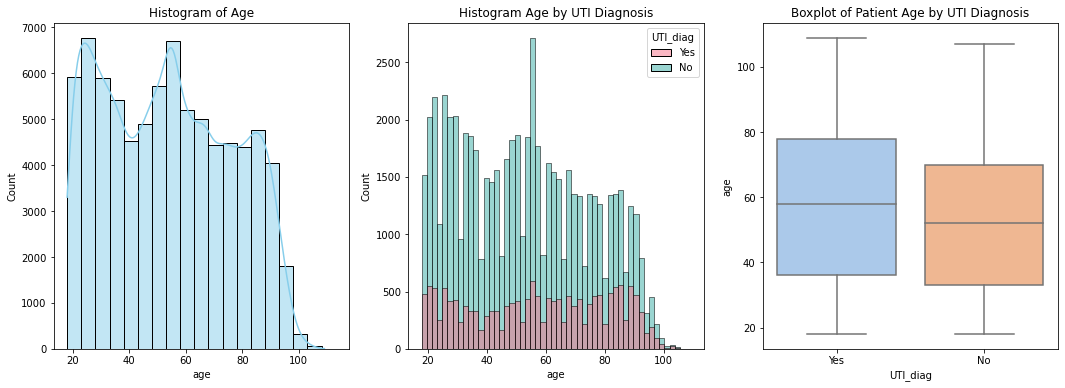

In [10]:
# Customize the color palette and style
custom_palette = ["#FF5733", "#33FF57", "#5733FF"]
sns.set_palette(custom_palette)

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Plot a histogram with a custom color
sns.histplot(data=df['age'], kde=True, binwidth=5, ax=ax1, color='skyblue')
ax1.set_title('Histogram of Age')

# Plot a histogram with different colors for each 'UTI_diag' value
ax2 = sns.histplot(x='age', hue='UTI_diag', data=df, ax=ax2, palette='husl')
ax2.set_title('Histogram Age by UTI Diagnosis')

# Plot a boxplot with custom colors
boxplot = sns.boxplot(x='UTI_diag', y='age', data=df, ax=ax3, palette='pastel')
ax3.set_title('Boxplot of Patient Age by UTI Diagnosis')

# Save the figure and display the plots
plt.savefig('histograms.png')
plt.show()

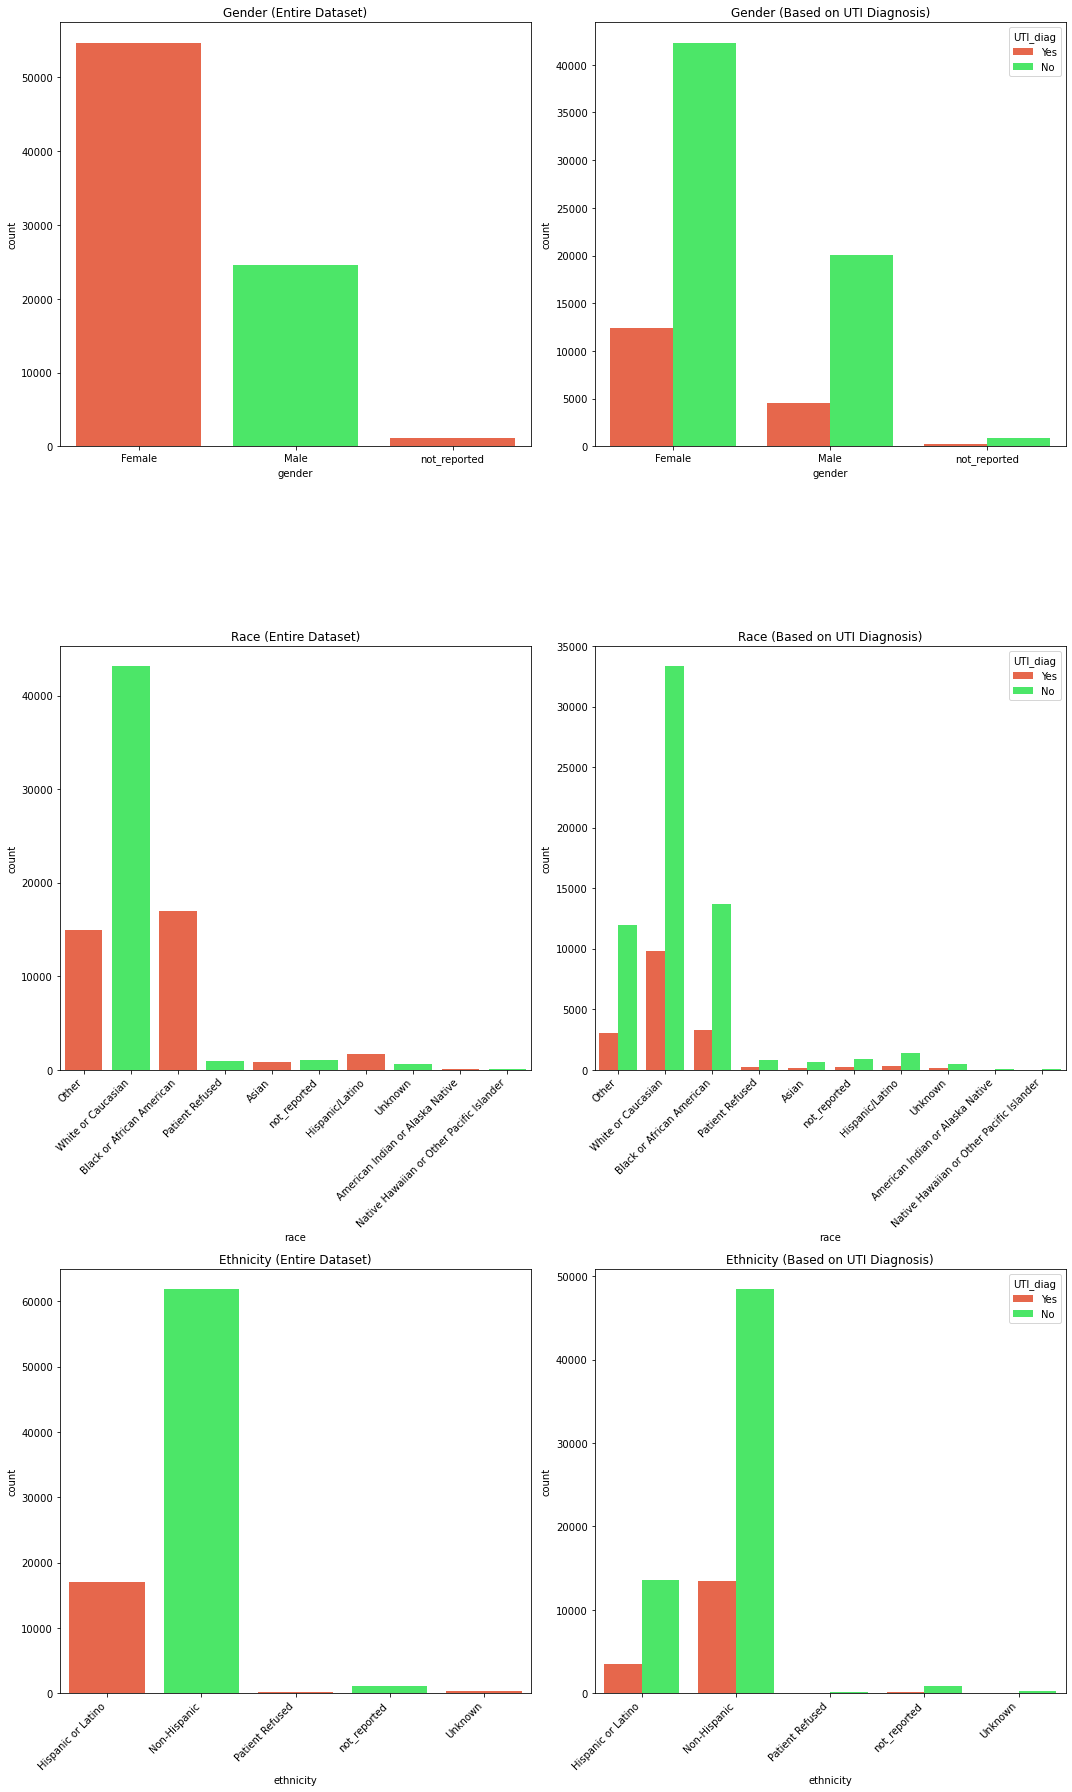

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a custom color palette
custom_palette = ['#FF5733', '#33FF57']

# Create subplots with two plots in each row
fig, axes = plt.subplots(3, 2, figsize=(15, 25))

# Barplot of 'gender' for the entire dataset
sns.countplot(x='gender', data=df, ax=axes[0, 0], palette=custom_palette)
axes[0, 0].set_title('Gender (Entire Dataset)')

# Barplot of 'gender' based on 'UTI_diag'
sns.countplot(x='gender', hue='UTI_diag', data=df, ax=axes[0, 1], palette=custom_palette)
axes[0, 1].set_title('Gender (Based on UTI Diagnosis)')

# Barplot of 'race' for the entire dataset with rotated x-axis labels
sns.countplot(x='race', data=df, ax=axes[1, 0], palette=custom_palette)
axes[1, 0].set_title('Race (Entire Dataset)')
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45, horizontalalignment='right')

# Barplot of 'race' based on 'UTI_diag' with rotated x-axis labels
sns.countplot(x='race', hue='UTI_diag', data=df, ax=axes[1, 1], palette=custom_palette)
axes[1, 1].set_title('Race (Based on UTI Diagnosis)')
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45, horizontalalignment='right')

# Barplot of 'ethnicity' for the entire dataset with rotated x-axis labels
sns.countplot(x='ethnicity', data=df, ax=axes[2, 0], palette=custom_palette)
axes[2, 0].set_title('Ethnicity (Entire Dataset)')
axes[2, 0].set_xticklabels(axes[2, 0].get_xticklabels(), rotation=45, horizontalalignment='right')

# Barplot of 'ethnicity' based on 'UTI_diag' with rotated x-axis labels
sns.countplot(x='ethnicity', hue='UTI_diag', data=df, ax=axes[2, 1], palette=custom_palette)
axes[2, 1].set_title('Ethnicity (Based on UTI Diagnosis)')
axes[2, 1].set_xticklabels(axes[2, 1].get_xticklabels(), rotation=45, horizontalalignment='right')

# Adjust the layout
plt.tight_layout()

# Save the figure and display the plots
plt.savefig('barplots.png')
plt.show()

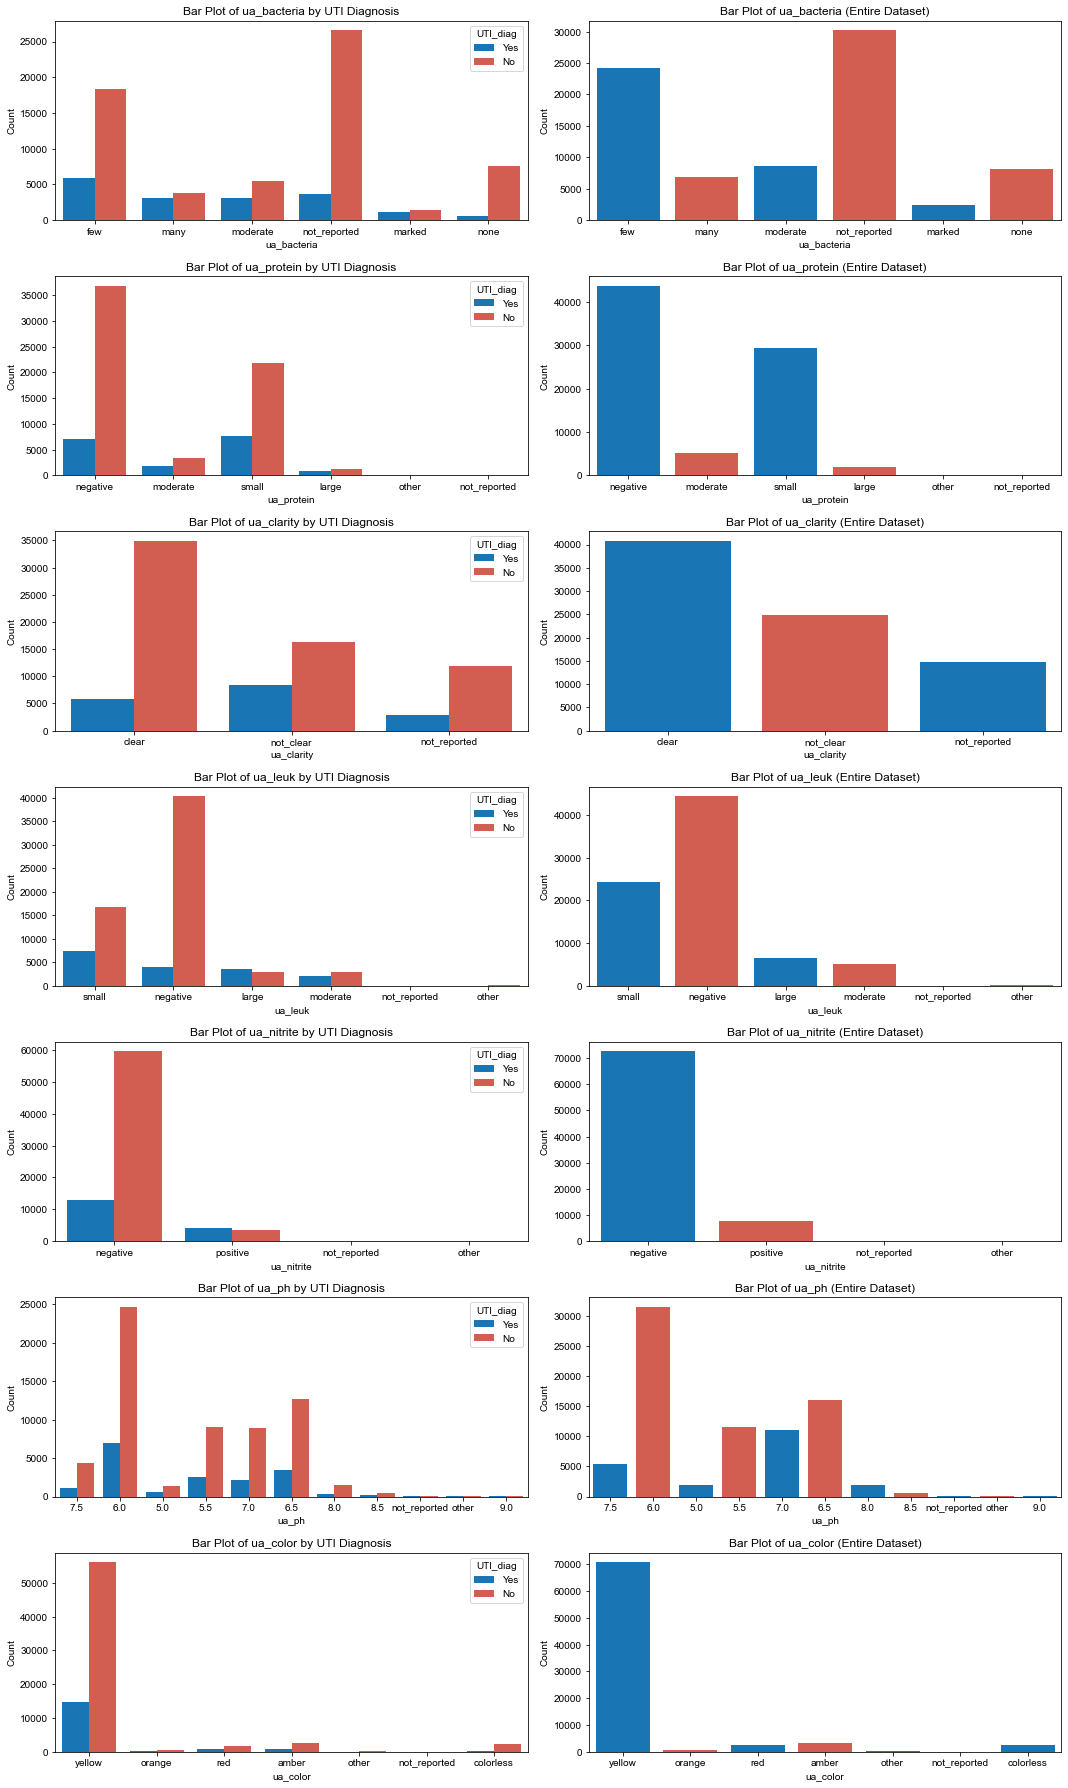

In [12]:
custom_palette = ["#007acc", "#e74c3c"]  # Blue and red colors

# List of urinalysis variables to plot
ua_variables = ["ua_bacteria", "ua_protein", 'ua_clarity', "ua_leuk", "ua_nitrite", "ua_ph", "ua_color"]

# Create subplots
fig, axes = plt.subplots(nrows=len(ua_variables), ncols=2, figsize=(15, 25))

for i, variable in enumerate(ua_variables):
    # Plot bar plot grouped by 'UTI_diag'
    sns.countplot(data=df, x=variable, hue='UTI_diag', ax=axes[i, 0], palette=custom_palette)
    axes[i, 0].set_title(f"Bar Plot of {variable} by UTI Diagnosis")
    axes[i, 0].set_xlabel(variable)
    axes[i, 0].set_ylabel("Count")

    # Plot bar plot for the entire dataset
    sns.countplot(data=df, x=variable, ax=axes[i, 1], palette=custom_palette)
    axes[i, 1].set_title(f"Bar Plot of {variable} (Entire Dataset)")
    axes[i, 1].set_xlabel(variable)
    axes[i, 1].set_ylabel("Count")

# Customize the plot style
sns.set(style="whitegrid")

plt.tight_layout()
plt.savefig('barplots.png')
plt.show()

#### Data Preprocessing

In [13]:
# Convert categorical variables
df[cat_vars.columns] = df[cat_vars.columns].astype(str)
df[cat_vars.columns] = df[cat_vars.columns].apply(LabelEncoder().fit_transform)

In [14]:
# List of dictionaries to store p-values for each categorical variable
chi2_p_values = []

# Chi-square test for each categorical variable
for col in df.columns:
    if col != 'UTI_diag':
        cross_tab = pd.crosstab(df[col], df['UTI_diag'])
        chi2, p, _, _ = stats.chi2_contingency(cross_tab)
        chi2_p_values.append({'Variable': col, 'Chi2 P-Value': p})

chi2_p_values_df = pd.DataFrame(chi2_p_values)

# Filtering statistically significant associations (e.g., p-value threshold of 0.05)
significant_associations = chi2_p_values_df[chi2_p_values_df['Chi2 P-Value'] < 0.05]

print(significant_associations)

                       Variable  Chi2 P-Value
0                  UCX_abnormal  0.000000e+00
1                   ua_bacteria  0.000000e+00
2                       ua_bili  2.147676e-53
3                      ua_blood  0.000000e+00
4                    ua_clarity  0.000000e+00
..                          ...           ...
209          SMOKING_DETERRENTS  3.585234e-04
210               THYROID_PREPS  8.425235e-16
211  UNCLASSIFIED_DRUG_PRODUCTS  4.445210e-22
212                    VITAMINS  3.771085e-08
213                       dispo  3.426427e-14

[175 rows x 2 columns]


### Feature Selection

##### Using Random Forest

In [15]:
# Convert numbers to numeric data type
num_vars = df.select_dtypes(include=['number'])
df[num_vars.columns] = num_vars.astype(float)

# Convert characters to character data type
cat_vars = df.select_dtypes(include=['object'])
df[cat_vars.columns] = cat_vars.astype(str)

# Save the DataFrame to a CSV file with the specified data types
df.to_csv('dat.csv', index=False)

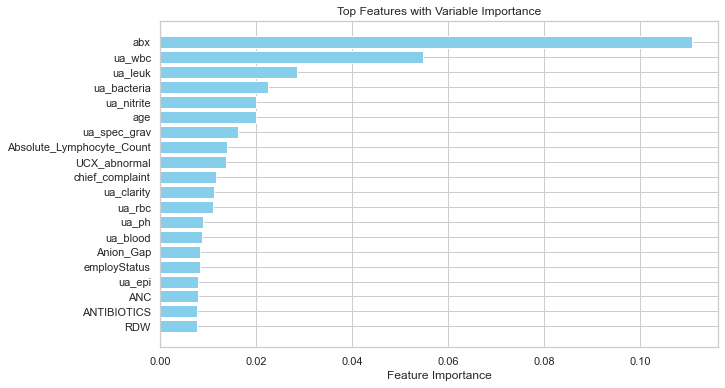

In [16]:
# Separate dataset into features and target variable
X = df.drop('UTI_diag', axis=1)
y = df['UTI_diag']

# Initialize the Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to your data
rf.fit(X, y)

# Get feature importances from the trained Random Forest model
feature_importances = rf.feature_importances_

# Sort features by importance in descending order
sorted_feature_indices = feature_importances.argsort()[::-1]

# Number of top features to select
num_top_features = 20  # Adjust this according to needs

# Select the top N important features
selected_features = X.iloc[:, sorted_feature_indices[:num_top_features]]

# The top feature column names and their importances
top_feature_names = X.columns[sorted_feature_indices[:num_top_features]]
top_feature_importances = feature_importances[sorted_feature_indices[:num_top_features]]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(top_feature_names, top_feature_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Top Features with Variable Importance')
plt.gca().invert_yaxis()  # Invert the y-axis to show the most important feature at the top
plt.savefig('features.png')
plt.show()

#### Features Selection Throughh ChiSq

In [17]:
from sklearn.feature_selection import SelectPercentile, chi2

# Assuming df is the DataFrame and 'UTI_diag' is the target variable
x_orig = df.drop(['UTI_diag'], axis=1)
y_orig = df['UTI_diag']

# Use chi2 as the score function
FeatureSelection = SelectPercentile(score_func=chi2, percentile=20)
x = FeatureSelection.fit_transform(x_orig, y_orig)

fe = FeatureSelection.get_support()
selected_features = []

for i in range(len(fe)):
    if fe[i]:
        selected_features.append(x_orig.columns[i])

# Ensure 'UTI_diag' is not in selected_features
if 'UTI_diag' in selected_features:
    selected_features.remove('UTI_diag')

print(selected_features)


['UCX_abnormal', 'ua_bacteria', 'ua_clarity', 'ua_epi', 'ua_nitrite', 'ua_rbc', 'ua_wbc', 'abd_soft', 'back_pain', 'fever', 'alert', 'oriented', 'dysuria', 'chief_complaint', 'age', 'employStatus', 'arrival', 'Absolute_Lymphocyte_Count', 'Alanine_Aminotransferase', 'Alkaline_Phosphatase', 'Aspartate_Aminotransferase', 'Basophils', 'BUN', 'Calcium', 'CO2', 'Creatinine', 'Eosinophils', 'Glucose', 'Hematocrit', 'Hemoglobin', 'Lymphocytes', 'MCH', 'MCV', 'Monocytes', 'Neutrophils', 'Potassium', 'RBC', 'Sodium', 'WBC', 'abx', 'Delirium__dementia__and_amnestic_and_other_cognitive_disorders', 'Urinary_tract_infections', 'ANTIBIOTICS']


In [18]:
#creating a df with the selected fetaures
selected_data = df[top_feature_names.tolist() + ['UTI_diag'] + ['gender']]

In [19]:
selected_data.head()

,abx,ua_wbc,ua_leuk,ua_bacteria,ua_nitrite,age,ua_spec_grav,Absolute_Lymphocyte_Count,UCX_abnormal,chief_complaint,ua_clarity,ua_rbc,ua_ph,ua_blood,Anion_Gap,employStatus,ua_epi,ANC,ANTIBIOTICS,RDW,UTI_diag,gender
0,1.0,1.0,5.0,0.0,0.0,83.0,1.020,5.0,1.0,0.0,0.0,5.0,5.0,2.0,0.0,2.0,5.0,0.0,0.0,0.0,1.0,0.0
1,1.0,5.0,2.0,1.0,0.0,81.0,1.017,5.0,0.0,21.0,0.0,5.0,2.0,5.0,2.0,5.0,3.0,2.0,0.0,1.0,1.0,0.0
2,0.0,5.0,5.0,0.0,0.0,78.0,1.016,5.0,1.0,1.0,0.0,3.0,0.0,2.0,1.0,5.0,5.0,0.0,0.0,3.0,0.0,0.0
3,1.0,1.0,0.0,1.0,0.0,84.0,1.016,5.0,1.0,10.0,1.0,5.0,1.0,2.0,2.0,5.0,3.0,3.0,0.0,1.0,1.0,0.0
4,0.0,5.0,5.0,3.0,3.0,55.0,1.030,5.0,0.0,0.0,0.0,5.0,2.0,2.0,1.0,1.0,3.0,3.0,0.0,1.0,0.0,1.0


#### Splitting the dataset

In [20]:
X = selected_data.drop('UTI_diag', axis=1)
y = selected_data['UTI_diag']

# Split into training, testing, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

#### Creating Evaluation Function

In [21]:
# Evaluation functions
def evaluate(model, X, y, label):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]

    accuracy = accuracy_score(y, y_pred)
    classification = classification_report(y, y_pred)

    fpr, tpr, _ = roc_curve(y, y_prob)
    roc_auc = auc(fpr, tpr)

    precision, recall, _ = precision_recall_curve(y, y_prob)
    pr_auc = auc(recall, precision)

    prob_true, prob_pred = calibration_curve(y, y_prob, n_bins=10, strategy='uniform')

    print(f"{label} Set Results:")
    print(f"Accuracy: {accuracy}")
    print("Classification Report:")
    print(classification)
    print(f"ROC AUC ({label}): {roc_auc:.2f}")
    print(f"PR AUC ({label}): {pr_auc:.2f}")

    # Create the ROC Curve plot
    plt.figure(figsize=(15, 4))
    plt.subplot(2, 3, 1)
    plt.plot(fpr, tpr, color='green', lw=2, label=f'ROC Curve ({label} AUC = {roc_auc:.2f})')  # Change color here
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve ({label})')
    plt.legend(loc='lower right')

    # Create the Precision-Recall Curve plot
    plt.subplot(2, 3, 2)
    plt.plot(recall, precision, color='purple', lw=2, label=f'PR Curve ({label} AUC = {pr_auc:.2f}')  # Change color here
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall (PR) Curve ({label})')
    plt.legend(loc='lower left')

    # Create the Calibration Curve plot
    plt.subplot(2, 3, 3)
    plt.plot(prob_pred, prob_true, marker='o', lw=2, label=f'Calibration Curve ({label})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title(f'Calibration Curve ({label})')
    plt.legend(loc='upper left')

#### Model 1 : Logistic Regression

In [22]:
# Initialize the logistic regression model
lr = LogisticRegression()

# Fit the model on training data
lr.fit(X_train, y_train)

# Evaluate on validation set
evaluate(lr, X_val, y_val, 'Validation')

# Evaluate on test set
evaluate(lr, X_test, y_test, 'Test')

plt.tight_layout()
plt.savefig('logisticregression.png')
plt.show()

NameError: name 'accuracy_score' is not defined

#### Model 2 : Random Forest

In [ ]:
# Initialize Random Forest classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model on training data
rfc.fit(X_train, y_train)

# Evaluate on validation set
evaluate(rfc, X_val, y_val, 'Validation')

# Evaluate on test set
evaluate(rfc, X_test, y_test, 'Test')

# Show the plots
plt.tight_layout()
plt.savefig('randomforests.png')
plt.show()

#### Model 3 : XGBoost

In [ ]:
# Define the parameter grid to search
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200, 300],
}

# Create an XGBoost classifier
xgb = XGBClassifier()

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(xgb, param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

In [ ]:
# Initialize the XGBoost classifier
xgbc = XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=300)

# Fit the model on the training data
xgbc.fit(X_train, y_train)

# Evaluate on the validation set
evaluate(xgbc, X_val, y_val, 'Validation')

# Evaluate on the test set
evaluate(xgbc, X_test, y_test, 'Test')

# Show the plots
plt.tight_layout()
plt.savefig('xgboost.png')
plt.show()

### Measuring Model Performance

In [ ]:
# Function to plot confusion matrix
def confusion_matrix_plot(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)

    # Define a custom color map
    cmap = plt.get_cmap("Blues")  # You can choose a different color map

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.colorbar()
    tick_marks = [0, 1]
    plt.xticks(tick_marks, ["Negative", "Positive"])
    plt.yticks(tick_marks, ["Negative", "Positive"])
    plt.xlabel('Predicted')
    plt.ylabel('True')

    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")

    plt.show()

# Initialize lists to store performance metrics
metrics = []

# Models we want to evaluate
model_names = ["Logistic Regression", "Random Forest", "XGBoost"]

# Iterate through the models and calculate metrics
for model_name, model in zip(model_names, [lr, rfc, xgbc]):
    y_test_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_test_prob > 0.5).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    auc_score = auc(fpr, tpr)

    metrics.append({
        "Model": model_name,
        "TP": tp,
        "FN": fn,
        "TN": tn,
        "FP": fp,
        "Sensitivity": f"{sensitivity:.2f}",
        "Specificity": f"{specificity:.2f}",
        "AUC": f"{auc_score:.2f}"
    })

    # Plot confusion matrix
    confusion_matrix_plot(y_test, y_pred, model_name)

# Create a DataFrame with the metrics
results_df = pd.DataFrame(metrics)


# Print the results as a table
print(results_df)


In [ ]:
# Define model names and models
models = [lr, rfc, xgbc]

# Initialize a figure
plt.figure(figsize=(8, 6))

# Plot ROC curves for each model
for model_name, model in zip(model_names, models):
    y_test_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    auc = roc_auc_score(y_test, y_test_prob)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for UTI Prediction Models')

# Add a legend
plt.legend(loc='lower right')

# Show the plot
plt.show()